In [2]:
import efel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from scipy.signal import find_peaks
from scipy import signal
from scipy import stats
import seaborn as sns
import glob
import matplotlib
sns.set_style("ticks")
sns.set_context("paper")
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42

In [17]:
# define some functions


def find_spike_times(voltages, dt, detection_level, min_interval):
    spike_times = []
    min_amplitude = -10
    last_spike_time = -min_interval
    for i in range(1, len(voltages)):
        t = i * dt
        if (voltages[i - 1] < detection_level <= voltages[i]) and (voltages[i] - voltages[i - 1] >= min_amplitude) and (t - last_spike_time >= min_interval):
            spike_times.append(t)
            last_spike_time = t
    return spike_times


def group_cvs(values, group_size):
    cvs = []
    if len(values) >= group_size:
        for i in range(0, len(values) - group_size, group_size):
            mu = np.mean(values[i:i + group_size])
            sigma = np.std(values[i:i + group_size])
            cvs.append(sigma / mu)
    return cvs


def segment(values, dx, x_min, x_max):
    return values[round(x_min / dx):round(x_max / dx)]


def find_slopes(values, dx):
    diffs = np.diff(values)
    slopes = [0] * len(values)
    slopes[0] = diffs[0] / dx
    slopes[-1] = diffs[-1] / dx
    for i in range(1, len(values) - 1):
        slopes[i] = (diffs[i - 1] + diffs[i]) / (2 * dx)
    return (slopes)


#use neo to import either voltage or current clamp data in the correct, scaled units!
def load_neo_file(file_name, **kwargs):
    import neo
    reader = neo.io.get_io(file_name)
    blocks = reader.read(**kwargs)
    new_blocks = []
    for bl in blocks:
        new_segments = []
        for seg in bl.segments:
            traces = []
            count_traces = 0
            analogsignals = seg.analogsignals

            for sig in analogsignals:
                traces.append({})
                traces[count_traces]['T'] = sig.times.rescale('ms').magnitude
                #need to write an if statement here for conversion
                try:
                    traces[count_traces]['A'] = sig.rescale('pA').magnitude
                except:
                    traces[count_traces]['V'] = sig.rescale('mV').magnitude
                count_traces += 1
            new_segments.append(traces)
        #new_blocks.append(efel_segments)
    return new_segments


def dvdt(path, sweep):
    table2 = []
    os.chdir(path)
    for filename in os.listdir():
        #check whether file is in the axgx or axgd format
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            for data in traces[sweep]:
                times = (data['T']) / 1000
                voltages = (data['V'])
                times -= times[0]
                dt = times[2] - times[1]
                detection_level = 0
                min_interval = 0.0001
                spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                isis = np.diff(spike_times)
                time_before = .018
                time_after = .015
                times_rel = list(np.arange(-time_before, time_after, dt))
                spike_voltages = []
                for i in range(0, len(spike_times)):
                    if time_before < spike_times[i] < times[-1] - time_after:
                        spike_voltages.append(
                            segment(voltages, dt, spike_times[i] - time_before, spike_times[i] + time_after))
                spike_voltage_arrays = [np.array(x) for x in spike_voltages]
                mean_spike_voltages = [np.mean(k) for k in zip(*spike_voltage_arrays)]
                dvdt_threshold = 20
                dvdt = find_slopes(mean_spike_voltages, dt)
                i = 1
                while dvdt[i] < dvdt_threshold:
                    i += 1
                v0 = mean_spike_voltages[i - 1]
                v1 = mean_spike_voltages[i]
                dvdt0 = dvdt[i - 1]
                dvdt1 = dvdt[i]
                v_threshold = v0 + (v1 - v0) * (dvdt_threshold - dvdt0) / (dvdt1 - dvdt0)
                pandas_dvdt = pd.DataFrame(dvdt)
                pandas_dvdt.rename(columns={0: filename}, inplace=True)  #naming the columns!
                pandas_membrane_voltages = pd.DataFrame(mean_spike_voltages)
            table2.append(pandas_dvdt)
            df_concat = pd.concat(table2, axis=1)

            df_concat.to_excel('dvdt' + 'master_file.xlsx', index=False)
    return (df_concat)


#write some functions for the rest of this stuff
def analyze_feature(path, feature):
    table2 = []
    os.chdir(path)
    for filename in os.listdir():
        table = pd.DataFrame(columns=[feature])  #create a table that has columns with the name you want
        table.name = feature  #the tables name
        if filename.endswith(".axgd") or filename.endswith(".axgx"):  #check for the filetype
            [traces] = efel.io.load_neo_file(filename, stim_start=500,
                                             stim_end=1500)  #load the trace, and define stim start and stop
            for data in traces:  #loop through these guys
                #table.rename(columns={feature:filename}, inplace=True) #renaming the columns with the correct file !
                feature_values = efel.getFeatureValues(data, [feature], raise_warnings=None)[
                    0]  #this is the feature extraction
                if feature_values[feature] is not None:
                    # Define the parameters for detection
                    efel.api.setThreshold(-10)  # Voltage threshold for detection
                    efel.api.setDerivativeThreshold(10)  # dV/dt threshold for detection
                    efel.setIntSetting('strict_stiminterval', True)
                    length = len(table)
                    table.loc[length, feature] = feature_values[feature][0]

                else:
                    efel.api.setThreshold(-10)  # Voltage threshold for detection
                    efel.api.setDerivativeThreshold(20)  # dV/dt threshold for detection
                    efel.setIntSetting('strict_stiminterval', True)
                    length = len(table)
                    table.loc[length, feature] = feature_values[feature]

            table2.append(table)
            df_concat = pd.concat(table2, axis=1)
            table.rename(columns={feature: filename}, inplace=True)  #renaming the columns with the correct file !
            #block of code to combine all of the generated excel workbooks into a single workbook
            df_concat.to_excel(feature + 'master_file.xlsx', index=False)
    Current_injected = np.linspace(-100.0, 500.0, num=61)
    table2 = df_concat.assign(Current_injected=Current_injected)
    #lineplot = df_concat.plot()
    #sns_lineplot = sns.relplot(data = table2, x = "Spikecount_stimint", y = 'Current_injected', kind="line")
    return (df_concat)

def mean_spike_voltages(path, sweep_start, sweep_end, metadata):
    spike_voltage_list = []
    os.chdir(path)
    for filename in os.listdir():
        #check whether file is in the axgx or axgd format
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            table2 = []
            for data in traces[sweep_start:sweep_end]:
                for p in data:
                    times = (p['T']) / 1000
                    voltages = (p['V'])
                    times -= times[0]
                    dt = times[2] - times[1]
                    detection_level = -10
                    min_interval = 0.0001
                    spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                    time_before = .018
                    time_after = .015
                    times_rel = list(np.arange(-time_before, time_after, dt))
                    spike_voltages = []
                    for i in range(0, len(spike_times)):
                        if time_before < spike_times[i] < times[-1] - time_after:
                            spike_voltages.append(
                                segment(voltages, dt, spike_times[i] - time_before, spike_times[i] + time_after))
                    spike_voltage_arrays = [np.array(x) for x in spike_voltages]
                    mean_spike_voltages = [np.mean(k) for k in zip(*spike_voltage_arrays)]
                    table2.append(mean_spike_voltages)
            table3 = np.array(table2)
            spike_voltage_list.append(table3)
            table3_df = pd.DataFrame(table3)
    global_mean_spike_voltages = pd.concat([pd.DataFrame(x) for x in spike_voltage_list], axis=0).mean(axis=0)
    global_mean_spike_voltages_df = pd.DataFrame(global_mean_spike_voltages)
    global_mean_spike_voltages_df.columns = ['Voltage (mV) ' + metadata]
    global_mean_spike_voltages_df.index = times_rel

    return global_mean_spike_voltages_df


def A_current(path, genotype):
    os.chdir(path)
    table2 = []
    table3 = []
    table4 = []
    for file_name in os.listdir():
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            file = load_neo_file(file_name)

            def monoExp(x, m, t, b):
                return m * np.exp(-t * x) + b

            for traces in file:
                for data in traces:
                    #this is for the first part of the A-current
                    times1 = data['T'][10100:17500]
                    amps1 = data['A'][10100:17500]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][2800:3000])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    max_amp1 = np.amax(amps1)  #find the maximum of the baseline subtracted amplitudes
                    #working on integration
                    flat_amps_1 = np.ndarray.flatten(
                        amps1)  #here we have to flatten our array into a single dimension so we can integrate
                    integrate1 = np.trapz(flat_amps_1)  #lets integrate this function using the numpy trapezius function
                    #this is for the substraction of the next part, so that we can get the substracted information
                    times2 = data['T'][
                             35100:42500]  #in order to extract a-current, we need to subtract from the inactivated standing current
                    amps2 = data['A'][
                            35100:42500]  #in order to extract a-current, we need to subtract from the inactivated standing current
                    #plt.plot(times2, amps2) #inspect
                    amps2 = amps2 - baseline  #find the baseline subtracted values for the inactivated standing current
                    max_amp2 = np.amax(amps2)  #find the max amplitude of that current
                    flat_amps_2 = np.ndarray.flatten(
                        amps2)  #flatten the baseline substracted inactivated portion for integration
                    integrate2 = np.trapz(flat_amps_2)  #integrate flattened baseline substracted sweeps
                    #now we need to substract that information to get the A current values
                    a_current_max_amp = max_amp1 - max_amp2  #this and the next calls are for the actual data we want, here max amp
                    a_current_auc = integrate1 - integrate2  #and here AUC
                    #from this point foward we are trying to put data together for iteration
                    #print('A-Current Max Amp is ', a_current_max_amp, 'pA')
                    #print('A-Current AUC is', a_current_auc, 'pA*s')
                    #generate a dataframe, must pass a 2d array
                    a_current_max_amp_array = np.array(a_current_max_amp, ndmin=2)
                    max_amp_df = pd.DataFrame(a_current_max_amp_array)
                    max_amp_df['file_name'] = file_name  #adding a column to add the filename
                    max_amp_df['Genotype'] = genotype

                    #generate a dataframe, must mass a 2d array
                    a_current_auc_array = np.array(a_current_auc, ndmin=2)
                    auc_df = pd.DataFrame(a_current_auc_array)
                    auc_df['file_name'] = file_name  #adding a column to add the filename

                    #fit a curve using scipy functionality - these params seem to work for a-current
                    p0 = [500, .001, 50]  #values near what we expect   #here
                    params, cv = scipy.optimize.curve_fit(monoExp, times1, flat_amps_1, p0, bounds=(-np.inf, np.inf),
                                                          maxfev=50000)  #here
                    m, t, b = params  #here
                    #m, t = params
                    sampleRate = 10_000  #hz
                    tauSec = (1 / t) / sampleRate
                    #determine quality of fit
                    squaredDiffs = np.square(flat_amps_1 - monoExp(times1, m, t, b))  #here
                    squaredDiffsFromMean = np.square(flat_amps_1 - np.mean(flat_amps_1))
                    rSquared = 1 - np.sum(squaredDiffs) / np.sum(
                        squaredDiffsFromMean)  #we want these, but they arent super important to display
                    #print(f"R^2 = {rSquared}")

                    #plot results
                    #plt.plot(times1, flat_amps_1, '.', label="data")
                    #plt.plot(times1, monoExp(times1, m, t, b), '--', label="fitted")  #here
                    #plt.show()
                    #plt.title("Fitted Expotential Curve")

                    #inspect the params
                    #print(f"Y = {m} * e^(-{t} * x) + {b}")   #the equations are important
                    #print(f"Tau = {tauSec * 1e6} us")    #but the tau is the most important
                    tau_array = np.array(tauSec * 1e4, ndmin=2)

                    tau_df = pd.DataFrame(tau_array)
                    tau_df['file_name'] = file_name  #adding a column to add the filename
                table2.append(max_amp_df)

                table3.append(auc_df)
                table4.append(tau_df)

        amp_concat = pd.concat(table2, ignore_index=True, axis=0)
        amp_concat.rename(columns={0: 'Max Amplitude(pA)'}, inplace=True)
        #amp_concat['Sweep'] = amp_concat.index%5 + 1
        every_4th_sweep_amp = amp_concat[amp_concat.index % 5 == 3]
        every_4th_sweep_amp.to_excel('a_current_amp' + '.xlsx', index=False)

        auc_concat = pd.concat(table3, ignore_index=True, axis=0)
        auc_concat.rename(columns={0: 'AUC (pA*s)'}, inplace=True)
        #auc_concat['Sweep'] = amp_concat.index%5 + 1
        every_4th_sweep_auc = auc_concat[amp_concat.index % 5 == 3]
        every_4th_sweep_auc.to_excel('a_current_auc' + '.xlsx', index=False)

        tau_concat = pd.concat(table4, ignore_index=True, axis=0)
        tau_concat.rename(columns={0: 'Decay Tau (ms)'}, inplace=True)
        #tau_concat['Sweep'] = amp_concat.index%5 + 1
        every_4th_sweep_tau = tau_concat[amp_concat.index % 5 == 3]
        every_4th_sweep_tau.to_excel('a_current_tau' + '.xlsx', index=False)
    return display(every_4th_sweep_amp), display(every_4th_sweep_auc), display(every_4th_sweep_tau)


def standing_K_current(path, genotype):
    os.chdir(path)
    table2 = []
    table3 = []
    table4 = []
    for file_name in os.listdir():
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            file = load_neo_file(file_name)
            for traces in file:
                for data in traces:
                    #this is for the first part of the A-current
                    times1 = data['T'][10100:17500]
                    amps1 = data['A'][10100:17500]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][2800:3000])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    max_amp1 = np.amax(amps1)  #find the maximum of the baseline subtracted amplitudes
                    #working on integration
                    flat_amps_1 = np.ndarray.flatten(
                        amps1)  #here we have to flatten our array into a single dimension so we can integrate
                    integrate1 = np.trapz(flat_amps_1)  #lets integrate this function using the numpy trapezius function
                    #this is for the substraction of the next part, so that we can get the substracted information
                    times2 = data['T'][
                             41444:45000]  #in order to extract a-current, we need to subtract from the inactivated standing current
                    amps2 = data['A'][
                            41444:45000]  #in order to extract a-current, we need to subtract from the inactivated standing current
                    #plt.plot(times2, amps2) #inspect
                    amps2 = amps2 - baseline  #find the baseline subtracted values for the inactivated standing current
                    max_amp2 = np.amax(amps2)  #find the max amplitude of that current
                    flat_amps_2 = np.ndarray.flatten(
                        amps2)  #flatten the baseline substracted inactivated portion for integration
                    integrate2 = np.trapz(flat_amps_2)  #integrate flattened baseline substracted sweeps
                    #now we need to substract that information to get the A current values
                    standing_k_max_amp = max_amp2  #this and the next calls are for the actual data we want, here max amp
                    standing_k_auc = integrate2  #and here AUC
                    #from this point foward we are trying to put data together for iteration
                    #print('A-Current Max Amp is ', a_current_max_amp, 'pA')
                    #print('A-Current AUC is', a_current_auc, 'pA*s')
                    #generate a dataframe, must pass a 2d array
                    a_current_max_amp_array = np.array(standing_k_max_amp, ndmin=2)
                    max_amp_df = pd.DataFrame(a_current_max_amp_array)
                    max_amp_df['file_name'] = file_name  #adding a column to add the filename
                    max_amp_df['Genotype'] = genotype

                    #generate a dataframe, must mass a 2d array
                    a_current_auc_array = np.array(standing_k_auc, ndmin=2)
                    auc_df = pd.DataFrame(a_current_auc_array)
                    auc_df['file_name'] = file_name  #adding a column to add the filename

                    #fit a curve using scipy functionality - these params seem to work for a-current

                table2.append(max_amp_df)
                table3.append(auc_df)

            amp_concat = pd.concat(table2, ignore_index=True, axis=0)
            amp_concat.rename(columns={0: 'Max Amplitude(pA)'}, inplace=True)
            #amp_concat['Sweep'] = amp_concat.index%5 + 1
            every_4th_sweep_amp = amp_concat[amp_concat.index % 5 == 3]
            every_4th_sweep_amp.to_excel('Standing K Amp' + '.xlsx', index=False)

            auc_concat = pd.concat(table3, ignore_index=True, axis=0)
            auc_concat.rename(columns={0: 'AUC (pA*s)'}, inplace=True)
            #auc_concat['Sweep'] = amp_concat.index%5 + 1
            every_4th_sweep_auc = auc_concat[amp_concat.index % 5 == 3]
            every_4th_sweep_auc.to_excel('Standing K AUC' + '.xlsx', index=False)
    return display(every_4th_sweep_amp), display(every_4th_sweep_auc)


def ahc_analysis(path, genotype):
    def monoExp(x, m, t, b):
        return m * np.exp(-t * x) + b

    ahc_append = []
    ahc_auc_append = []
    ahc_max_amp_append = []
    auc_append = []
    tau_append = []
    ahc_max_amp_df_append = []
    os.chdir(path)
    for file_name in os.listdir():
        tabla = []
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for sk_data in traces:
                for data in sk_data:
                    #this is for the first part of the A-current
                    times1 = data['T'][322002:328000]  #this is 16.101 to 16.213
                    amps1 = data['A'][322002:328000]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][318400:319600])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    amps1_df = pd.DataFrame(amps1)  #we generated all the amps into a dataframe, check
                    flat_times = np.ndarray.flatten(
                        times1)  #we have all of the times into a flattened numpy array, check
                    tabla.append(amps1_df)  #and we appended all of the amps into a dataframe
                amps_concat = pd.concat(tabla,
                                        axis=1)  #this is correct - we put all the amps for a given trace into a dataframe
            #now we need to average those dataframes by row
            averaged_sk_trace = amps_concat.mean(
                axis=1)  #woohooo this is the averaged SK trace in a pd.DF, this is what we want to work with from here on out!

            #Block of code of AHC Max Amp !
            ahc_max_amp = pd.DataFrame.max(
                averaged_sk_trace)  #max of the whole ahc, not just sk component, This is the value!!
            #figure out to how put this in a format that can be read and concatenated
            ahc_max_amp_array = np.array(ahc_max_amp, ndmin=2)  #these lines are new
            ahc_max_amp_df = pd.DataFrame(
                ahc_max_amp_array)  #these lines are new - this line of code produces the correct values but does not add them into an appended dataframe. which is obviously a problem. the task is to get these and all the values from the other two measures into a single dataframe so that in the future we may compare across groups within python<3
            ahc_max_amp_df['file_name'] = file_name  #adding a column to add the filename
            ahc_max_amp_df['Genotype'] = genotype
            ahc_append.append(ahc_max_amp_df)  #Here!
            ahc_max_amp_concat_df = pd.concat(ahc_append)  #This is the variable for ahc

            #Block of code for AHC AUC
            averaged_sk_trace_as_np = averaged_sk_trace.to_numpy()
            flattened_average_sk_trace = np.ndarray.flatten(averaged_sk_trace_as_np)
            ahc_auc = np.trapz(flattened_average_sk_trace)  #this is the auc of the whole ahc
            #bit of code to get the ahc auc into readable condition
            ahc_auc_array = np.array(ahc_auc, ndmin=2)
            ahc_auc_df = pd.DataFrame(ahc_auc_array)  #here we have the auc data in a dataframe
            ahc_auc_df['file_name'] = file_name
            ahc_auc_append.append(ahc_auc_df)
            ahc_auc_concat_df = pd.concat(ahc_auc_append)  #this is the variable for auc

            #Block of code for kinetics
            trace_for_kinetics = flattened_average_sk_trace[30:]
            times_for_kinetics = flat_times[30:]
            trace_for_kinetics_pd = pd.DataFrame(trace_for_kinetics)
            #trace_for_kinetics_pd.to_excel("trace_for_kinetics_pd.xlsx")
            times_for_kinetics_pd = pd.DataFrame(times_for_kinetics)
            #times_for_kinetics_pd.to_excel("times_for_kinetics_pd.xlsx")

            #fit the curve for inactivation tau
            p0 = [1.187 * 10 ** 150., .02, +16]  #values near what we expect   #here
            params, cv = scipy.optimize.curve_fit(monoExp, times_for_kinetics, trace_for_kinetics, p0,
                                                  bounds=(-np.inf, np.inf),
                                                  maxfev=100000)  #here  #this fits the training curve with an r-squared of 0.97
            m, t, b = params  #here
            #m, t = params
            sampleRate = 20_000  #hz
            tauSec = (1 / t) / sampleRate

            #determine quality of fit
            squaredDiffs = np.square(trace_for_kinetics - monoExp(times_for_kinetics, m, t, b))  #here
            squaredDiffsFromMean = np.square(trace_for_kinetics - np.mean(trace_for_kinetics))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(
                squaredDiffsFromMean)  #we want these, but they arent super important to display
            #print(f"R^2 = {rSquared}")

            #plot results
            #plt.plot(times_for_kinetics, trace_for_kinetics, '.', label="data")
            #plt.plot(times_for_kinetics, monoExp(times_for_kinetics, m, t, b), '--', label="fitted")  #here
            plt.show()
            #plt.title("Fitted Expotential Curve")

            #inspect the params
            #print(f"Y = {m} * e^(-{t} * x) + {b}")   #the equations are important
            #print(f"Tau = {tauSec * 1e6} us")    #but the tau is the most important
            plt.show()
            tau_flat_ms = tauSec * 1e4

            #Bit of code to get tau into working order
            tau_array = np.array(tauSec * 1e4, ndmin=2)
            tau_df = pd.DataFrame(tau_array)
            tau_df['file_name'] = file_name
            tau_append.append(tau_df)
            tau_concat_df = pd.concat(tau_append)  #this is the variable for tau

    #lets rename columns and export to excel for each of our metrics
    ahc_max_amp_concat_df.rename(columns={0: 'AHC Max Amplitude (pA)'}, inplace=True)
    ahc_max_amp_concat_df.to_excel('ahc_max_amp_' + '.xlsx', index=False)

    ahc_auc_concat_df.rename(columns={0: 'AHC AUC (pA*s)'}, inplace=True)
    ahc_auc_concat_df.to_excel('ahc_auc' + '.xlsx', index=False)

    tau_concat_df.rename(columns={0: 'Decay Tau (ms)'}, inplace=True)
    tau_concat_df.to_excel('ahc_tau' + '.xlsx', index=False)

    return display(ahc_max_amp_concat_df), display(ahc_auc_concat_df), display(tau_concat_df)


def sk_analysis(path, genotype):
    def monoExp(x, m, t, b):
        return m * np.exp(-t * x) + b

    ahc_append = []
    ahc_auc_append = []

    ahc_max_amp_append = []
    auc_append = []
    tau_append = []
    ahc_max_amp_df_append = []
    os.chdir(path)

    for file_name in os.listdir():
        tabla = []
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for sk_data in traces:
                for data in sk_data:
                    #this is for the first part of the A-current
                    times1 = data['T'][322440:328000]  #this is 16.122 to 16.213
                    amps1 = data['A'][322440:328000]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][318400:319600])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    amps1_df = pd.DataFrame(amps1)  #we generated all the amps into a dataframe, check
                    flat_times = np.ndarray.flatten(
                        times1)  #we have all of the times into a flattened numpy array, check
                    tabla.append(amps1_df)  #and we appended all of the amps into a dataframe
                amps_concat = pd.concat(tabla,
                                        axis=1)  #this is correct - we put all the amps for a given trace into a dataframe
            #now we need to average those dataframes by row
            averaged_sk_trace = amps_concat.mean(
                axis=1)  #woohooo this is the averaged SK trace in a pd.DF, this is what we want to work with from here on out!

            #Block of code of AHC Max Amp !
            ahc_max_amp = pd.DataFrame.max(
                averaged_sk_trace)  #max of the whole ahc, not just sk component, This is the value!!
            #figure out to how put this in a format that can be read and concatenated
            ahc_max_amp_array = np.array(ahc_max_amp, ndmin=2)  #these lines are new
            ahc_max_amp_df = pd.DataFrame(
                ahc_max_amp_array)  #these lines are new - this line of code produces the correct values but does not add them into an appended dataframe. which is obviously a problem. the task is to get these and all the values from the other two measures into a single dataframe so that in the future we may compare across groups within python<3
            ahc_max_amp_df['file_name'] = file_name  #adding a column to add the filename
            ahc_max_amp_df['genotype'] = genotype  #adding a column to add the genotype
            ahc_append.append(ahc_max_amp_df)  #Here!
            ahc_max_amp_concat_df = pd.concat(ahc_append)  #This is the variable for ahc

            #Block of code for AHC AUC
            averaged_sk_trace_as_np = averaged_sk_trace.to_numpy()
            flattened_average_sk_trace = np.ndarray.flatten(averaged_sk_trace_as_np)
            ahc_auc = np.trapz(flattened_average_sk_trace)  #this is the auc of the whole ahc
            #bit of code to get the ahc auc into readable condition
            ahc_auc_array = np.array(ahc_auc, ndmin=2)
            ahc_auc_df = pd.DataFrame(ahc_auc_array)  #here we have the auc data in a dataframe
            ahc_auc_df['file_name'] = file_name
            ahc_auc_append.append(ahc_auc_df)
            ahc_auc_concat_df = pd.concat(ahc_auc_append)  #this is the variable for auc

            #Block of code for kinetics
            trace_for_kinetics = flattened_average_sk_trace[30:]
            times_for_kinetics = flat_times[30:]
            trace_for_kinetics_pd = pd.DataFrame(trace_for_kinetics)
            #trace_for_kinetics_pd.to_excel("trace_for_kinetics_pd.xlsx")
            times_for_kinetics_pd = pd.DataFrame(times_for_kinetics)
            #times_for_kinetics_pd.to_excel("times_for_kinetics_pd.xlsx")

            #fit the curve for inactivation tau
            p0 = [1.187 * 10 ** 150., .02, +16]  #values near what we expect   #here
            params, cv = scipy.optimize.curve_fit(monoExp, times_for_kinetics, trace_for_kinetics, p0,
                                                  bounds=(-np.inf, np.inf),
                                                  maxfev=100000)  #here  #this fits the training curve with an r-squared of 0.97
            m, t, b = params  #here
            #m, t = params
            sampleRate = 20_000  #hz
            tauSec = (1 / t) / sampleRate

            #determine quality of fit
            squaredDiffs = np.square(trace_for_kinetics - monoExp(times_for_kinetics, m, t, b))  #here
            squaredDiffsFromMean = np.square(trace_for_kinetics - np.mean(trace_for_kinetics))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(
                squaredDiffsFromMean)  #we want these, but they arent super important to display
            #print(f"R^2 = {rSquared}")

            #plot results
            #plt.plot(times_for_kinetics, trace_for_kinetics, '.', label="data")
            #plt.plot(times_for_kinetics, monoExp(times_for_kinetics, m, t, b), '--', label="fitted")  #here
            plt.show()
            #plt.title("Fitted Expotential Curve")

            #inspect the params
            #print(f"Y = {m} * e^(-{t} * x) + {b}")   #the equations are important
            #print(f"Tau = {tauSec * 1e6} us")    #but the tau is the most important
            plt.show()
            tau_flat_ms = tauSec * 1e4

            #Bit of code to get tau into working order
            tau_array = np.array(tauSec * 1e4, ndmin=2)
            tau_df = pd.DataFrame(tau_array)
            tau_df['file_name'] = file_name
            tau_append.append(tau_df)
            tau_concat_df = pd.concat(tau_append)  #this is the variable for tau

    #lets rename columns and export to excel for each of our metrics
    ahc_max_amp_concat_df.rename(columns={0: 'SK Max_Amplitude (pA)'}, inplace=True)
    ahc_max_amp_concat_df.to_excel('sk_max_amp_' + '.xlsx', index=False)

    ahc_auc_concat_df.rename(columns={0: 'SK AUC (pA*s)'}, inplace=True)
    ahc_auc_concat_df.to_excel('sk_auc' + '.xlsx', index=False)

    tau_concat_df.rename(columns={0: 'SK Decay Tau (ms)'}, inplace=True)
    tau_concat_df.to_excel('sk_tau' + '.xlsx', index=False)

    return display(ahc_max_amp_concat_df), display(ahc_auc_concat_df), display(tau_concat_df)


def generalized_v_clamp_analysis(path, sampling_rate_hz, analysis_time_start_ms, analysis_time_end_ms,
                                 baseline_start_ms, baseline_end_ms, time_from_analysis_start_time_for_decay_tau):
    os.chdir(path)
    ahc_append = []
    ahc_auc_append = []
    tau_append = []

    def monoExp(x, m, t, b):
        return m * np.exp(-t * x) + b

    #here we need to convert sampling rate to time in ms, and as integers, otherwise we cannot slice with them
    analysis_time_start1 = int(sampling_rate_hz * analysis_time_start_ms)
    analysis_time_end1 = int(sampling_rate_hz * analysis_time_end_ms)
    baseline_start1 = int(sampling_rate_hz * baseline_start_ms)
    baseline_end1 = int(sampling_rate_hz * baseline_end_ms)
    time_from_analysis_start_time_for_decay_tau1 = int(sampling_rate_hz * time_from_analysis_start_time_for_decay_tau)
    for file_name in os.listdir():
        tabla = []
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for sk_data in traces:
                for data in sk_data:
                    #this is for the first part of the A-current
                    #time1_slice = slice(analysis_time_start1:analysis_time_end1)
                    times1 = data['T'][analysis_time_start1:analysis_time_end1]  #this is 16.101 to 16.213
                    amps1 = data['A'][analysis_time_start1:analysis_time_end1]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][
                                       baseline_start1:baseline_end1])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    amps1_df = pd.DataFrame(amps1)
                    flat_times = np.ndarray.flatten(times1)
                    tabla.append(amps1_df)
                amps_concat = pd.concat(tabla, axis=1)
            averaged_sk_trace = amps_concat.mean(axis=1)  #woohooo this is the averaged SK trace in a pd.DF

            #Block of code for AHC Max Amplitude in pA
            ahc_max_amp = pd.DataFrame.max(averaged_sk_trace)  #max of the whole ahc, not just sk component
            ahc_max_amp_array = np.array(ahc_max_amp, ndmin=2)  #these lines are new
            ahc_max_amp_df = pd.DataFrame(ahc_max_amp_array)  #these lines are new
            ahc_max_amp_df['file_name'] = file_name
            ahc_append.append(ahc_max_amp_df)  #Here!
            ahc_max_amp_concat_df = pd.concat(ahc_append)

            #Block of code for AUC
            averaged_sk_trace_as_np = averaged_sk_trace.to_numpy()
            flattened_average_sk_trace = np.ndarray.flatten(averaged_sk_trace_as_np)
            ahc_auc = np.trapz(flattened_average_sk_trace)  #this is the auc of the whole ahc
            #bit of code to get the ahc auc into readable condition
            ahc_auc_array = np.array(ahc_auc, ndmin=2)
            ahc_auc_df = pd.DataFrame(ahc_auc_array)  #here we have the auc data in a dataframe
            ahc_auc_df['file_name'] = file_name
            ahc_auc_append.append(ahc_auc_df)
            ahc_auc_concat_df = pd.concat(ahc_auc_append)

            #Block of code for decay tau
            trace_for_kinetics = flattened_average_sk_trace[time_from_analysis_start_time_for_decay_tau1:]
            times_for_kinetics = flat_times[time_from_analysis_start_time_for_decay_tau1:]
            trace_for_kinetics_pd = pd.DataFrame(trace_for_kinetics)
            #trace_for_kinetics_pd.to_excel("trace_for_kinetics_pd.xlsx")
            times_for_kinetics_pd = pd.DataFrame(times_for_kinetics)
            #times_for_kinetics_pd.to_excel("times_for_kinetics_pd.xlsx")

            #fit the curve for inactivation tau
            p0 = [1.187 * 10 ** 150., .02, +16]  #values near what we expect   #here
            params, cv = scipy.optimize.curve_fit(monoExp, times_for_kinetics, trace_for_kinetics, p0,
                                                  bounds=(-np.inf, np.inf),
                                                  maxfev=100000)  #here  #this fits the training curve with an r-squared of 0.97
            m, t, b = params  #here
            #m, t = params
            sampleRate = sampling_rate_hz  #hz
            tauSec = (1 / t) / sampleRate

            #determine quality of fit
            squaredDiffs = np.square(trace_for_kinetics - monoExp(times_for_kinetics, m, t, b))  #here
            squaredDiffsFromMean = np.square(trace_for_kinetics - np.mean(trace_for_kinetics))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(
                squaredDiffsFromMean)  #we want these, but they arent super important to display
            #print(f"R^2 = {rSquared}")

            #plot results
            #plt.plot(times_for_kinetics, trace_for_kinetics, '.', label="data")
            #plt.plot(times_for_kinetics, monoExp(times_for_kinetics, m, t, b), '--', label="fitted")  #here
            plt.show()
            #plt.title("Fitted Expotential Curve")

            #inspect the params
            #print(f"Y = {m} * e^(-{t} * x) + {b}")   #the equations are important
            #print(f"Tau = {tauSec * 1e6} us")    #but the tau is the most important
            plt.show()
            tau_flat_ms = tauSec * 1e4
            tau_array = np.array(tauSec * 1e4, ndmin=2)
            tau_df = pd.DataFrame(tau_array)
            tau_df['file_name'] = file_name
            tau_append.append(tau_df)
            tau_concat_df = pd.concat(tau_append)
    #for file_name_1 in os.listdir():
    #if file_name_1.endswith(".axgd") or file_name_1.endswith(".axgx"):
    #filename = file_name_1

    #Block of code to add a column containing the file name for each metric, change the column name, and print to excel
    #ahc_max_amp_concat_df['File'] = filename
    ahc_max_amp_concat_df.rename(columns={0: 'Max Amplitude(pA)'}, inplace=True)
    ahc_max_amp_concat_df.to_excel('Gen_' + 'ahc_max_amp' + '.xlsx', index=False)
    #bit of tricky code for the auc

    #ahc_auc_concat_df['File'] = filename
    ahc_auc_concat_df.rename(columns={0: 'AUC (pA*s)'}, inplace=True)
    ahc_auc_concat_df.to_excel('Gen_' + 'ahc_auc' + '.xlsx', index=False)

    #same bit for the decay tau
    #tau_concat_df['File'] = filename
    tau_concat_df.rename(columns={0: 'Tau (ms)'}, inplace=True)
    tau_concat_df.to_excel('Gen_' + 'ahc_tau' + '.xlsx', index=False)
    return display(ahc_max_amp_concat_df), display(ahc_auc_concat_df), display(tau_concat_df)


def AHP(path, sweep):
    ahp_array = []
    os.chdir(path)
    for file_name in os.listdir():
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            file = load_neo_file(file_name)
            for traces in file:
                for data in traces:
                    times1 = data['T'][15400:20000]
                    volts1 = data['V'][15400:20000]
                    baseline = data['V'][3500:4700]
                    min_volts = np.min(volts1)
                    ahp_min = baseline - min_volts
                    max_ahp = ahp_min[sweep]

            ahp_array.append(max_ahp)
    ahp_df = pd.DataFrame(ahp_array)
    ahp_df.to_excel('AHP_min' + '.xlsx', index=False)
    #ahp_concat = pd.concat(ahp_array, ignore_index=True, axis=0)
    return display(ahp_df)


#time to peak for AHC current
def time_to_peak(path, sampling_rate_hz, analysis_time_start_ms, analysis_time_end_ms, baseline_start_ms,
                 baseline_end_ms, time_to_add_to_time_to_peak_in_ms):
    os.chdir(path)
    time_to_peak_append = []

    #here we need to convert sampling rate to time in ms, and as integers, otherwise we cannot slice with them
    analysis_time_start1 = int(sampling_rate_hz * analysis_time_start_ms)
    analysis_time_end1 = int(sampling_rate_hz * analysis_time_end_ms)
    baseline_start1 = int(sampling_rate_hz * baseline_start_ms)
    baseline_end1 = int(sampling_rate_hz * baseline_end_ms)

    for file_name in os.listdir():
        tabla = []
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for sk_data in traces:
                for data in sk_data:
                    #this is for the first part of the A-current
                    #time1_slice = slice(analysis_time_start1:analysis_time_end1)
                    times1 = data['T'][analysis_time_start1:analysis_time_end1]  #this is 16.101 to 16.213
                    amps1 = data['A'][analysis_time_start1:analysis_time_end1]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][
                                       baseline_start1:baseline_end1])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    amps1_df = pd.DataFrame(amps1)
                    flat_times = np.ndarray.flatten(times1)
                    tabla.append(amps1_df)
                amps_concat = pd.concat(tabla, axis=1)
            averaged_sk_trace = amps_concat.mean(axis=1)  #woohooo this is the averaged SK trace in a pd.DF
            averaged_sk_trace_df = pd.DataFrame(averaged_sk_trace)
            #copy the above code to generate a time to peak for the AHC current, or any current you like
            index_of_max = pd.DataFrame.idxmax(averaged_sk_trace_df)
            ms_from_start_analysis_to_max = ((
                                                         index_of_max / sampling_rate_hz) * 1e3) + time_to_add_to_time_to_peak_in_ms  #lets think about this line of code
            ms_from_start_analysis_to_max_array = np.array(ms_from_start_analysis_to_max)
            time_to_peak_df = pd.DataFrame(ms_from_start_analysis_to_max_array)
            time_to_peak_df['file_name'] = file_name
            time_to_peak_append.append(time_to_peak_df)
            time_to_peak_concat_df = pd.concat(time_to_peak_append)
    #time_to_peak_concat_df['File'] = file_name
    time_to_peak_concat_df.rename(columns={0: 'Time to Peak (ms)'}, inplace=True)
    time_to_peak_concat_df.to_excel('Gen_' + 'time_to_peak' + '.xlsx', index=False)

    return display(time_to_peak_concat_df)


#Cell attached analysis which takes the path to the directory holding the action current traces
def cell_attached_analysis_2(path, genotype):
    os.chdir(path)
    concat_cv_append = []
    concat_frequency_append = []
    for file_name in os.listdir():
        cv_of_isi_append = []
        frequency_append = []
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for cell_attached_data in traces:
                for data in cell_attached_data:
                    times1 = data['T']
                    amps1 = data['A']
                    baseline = np.average(data['A'])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse
                    #we generated all the amps into a dataframe, check
                    sampling_rate = 50_000
                    #Filter the signal (savgol)
                    window_length = 75
                    deriv = 0
                    polyorder = 2
                    current_filtered = signal.savgol_filter(x=amps1, window_length=window_length, polyorder=polyorder,
                                                            deriv=deriv, axis=0,
                                                            cval='nearest')  #convolve with a small window, low order polynomial
                    amps1_df = pd.DataFrame(current_filtered)
                    std_trace = np.std(current_filtered)

                    flat_amps_concat_np = current_filtered.flatten('F')
                    flat_amps_concat_np_df = pd.DataFrame(flat_amps_concat_np)
                    median_trace = np.median(flat_amps_concat_np)
                    flat_times = times1.flatten('F')
                    if std_trace < 3.5:
                        width = 0.9 * sampling_rate / 1000
                        peaks, peaks_dict = find_peaks(-flat_amps_concat_np,  # signal
                                                       height=(1.3 * std_trace, 200),
                                                       # Min and max thresholds to detect peaks.
                                                       threshold=None,
                                                       # Min and max vertical distance to neighboring samples.
                                                       distance=(1000),  # Min horizontal distance between peaks.
                                                       prominence=12,
                                                       # Vertical distance between the peak and lowest contour line.
                                                       width=width,
                                                       # Min required width (in bins). E.g. For 50Khz, 10 bins = 5 ms.
                                                       wlen=None,  # Window length to calculate prominence.
                                                       rel_height=1.0,
                                                       # Relative height at which the peak width is measured.
                                                       plateau_size=None)
                        # plt.figure(figsize=(16, 8))
                        # plt.plot(flat_amps_concat_np)
                        # plt.plot(peaks, flat_amps_concat_np[peaks], "x")
                        # plt.show()
                        if len(peaks) > 2:
                            isi_s = np.diff(peaks, axis=0, prepend=peaks[0])[1:] / sampling_rate
                            isis_pd = pd.DataFrame(isi_s)
                            isi_std = np.std(isi_s)
                            isi_mean = np.mean(isi_s)
                            cv_of_isi = isi_std / isi_mean
                            cv_array = np.array(cv_of_isi)
                            #frequency based on ISIs
                            frequency = np.mean(1 / isi_s)
                            frequency_based_on_time = len(peaks) / 10
                            cv_of_isi_append.append(cv_of_isi)
                            frequency_append.append(frequency)
            mean_cv = np.mean(cv_of_isi_append)
            mean_cv_array = np.array(mean_cv, ndmin=2)
            mean_cv_df = pd.DataFrame(mean_cv_array)
            mean_cv_df['file_name'] = file_name
            mean_cv_df['Genotype'] = genotype
            concat_cv_append.append(mean_cv_df)
            mean_frequency = np.mean(frequency_append)
            mean_frequency_array = np.array(mean_frequency, ndmin=2)
            mean_frequency_df = pd.DataFrame(mean_frequency_array)
            mean_frequency_df['file_name'] = file_name
            mean_frequency_df['Genotype'] = genotype
            concat_frequency_append.append(mean_frequency_df)
    cv_append_concat = pd.concat(concat_cv_append)
    cv_append_concat.rename(columns={0: 'CV of ISI'}, inplace=True)
    cv_append_concat.to_excel('CV of ISI' + '.xlsx', index=False)
    frequency_append_concat = pd.concat(concat_frequency_append)
    frequency_append_concat.rename(columns={0: 'Mean Frequency (Hz)'}, inplace=True)
    frequency_append_concat.to_excel('Cell Attached Frequency (Hz)' + '.xlsx', index=False)
    return display(cv_append_concat), display(frequency_append_concat)


def input_resistance(path, sweep_start, sweep_end):
    #we are going to define input resistance as voltage_deflection_vb_ssse / stimulus_current, because we cannot extract stimulus current from the axograph metadata, we need to build a column in a pandas dataframe, and then we need to divide those two columns providing us a measure.
    table2 = []
    feature = 'voltage_deflection_vb_ssse'
    os.chdir(path)
    for filename in os.listdir():
        table = pd.DataFrame(columns=[feature])  #create a table that has columns with the name you want
        table.name = feature  #the tables name
        if filename.endswith(".axgd") or filename.endswith(".axgx"):  #check for the filetype
            [traces] = efel.io.load_neo_file(filename, stim_start=500,
                                             stim_end=1500)  #load the trace, and define stim start and stop
            for data in traces[sweep_start:sweep_end]:  #loop through these guys
                #table.rename(columns={feature:filename}, inplace=True) #renaming the columns with the correct file !
                feature_values = efel.getFeatureValues(data, [feature], raise_warnings=None)[
                    0]  #this is the feature extraction
                if feature_values[feature] is not None:
                    # Define the parameters for detection
                    efel.api.setThreshold(-10)  # Voltage threshold for detection
                    efel.api.setDerivativeThreshold(20)  # dV/dt threshold for detection
                    efel.setIntSetting('strict_stiminterval', True)
                    length = len(table)
                    table.loc[length, feature] = feature_values[feature][0]

            Current_injected = np.linspace(-50.0, -10, num=5)
            current_injected_df = pd.DataFrame(Current_injected)

            table2.append(table)

            df_concat = pd.concat(table2, axis=1)

            table.rename(columns={feature: feature}, inplace=True)  #renaming the columns with the correct file !

        #block of code to combine all of the generated excel workbooks into a single workbook
        #df_concat.to_excel(feature + 'master_file.xlsx', index=False)
    Current_injected = np.linspace(-50.0, -10, num=5)
    table2 = df_concat.assign(Current_injected=Current_injected)
    voltage_deflection_vb_ssse_values = np.array(table2['voltage_deflection_vb_ssse'])
    current_injected_values = np.array(table2['Current_injected'])
    voltage_values_df = pd.DataFrame(voltage_deflection_vb_ssse_values)
    #option 1 - this divides the voltage deflec values by the injected current, i like this option less
    input_resistances = []
    for column in voltage_values_df.columns:
        input_resistance = (voltage_values_df[column]) / Current_injected
        input_resistance_array = np.asarray(input_resistance)
        input_resistance_df = pd.DataFrame(input_resistance_array)
        input_resistances.append(input_resistance_df)

    input_resistances_concat = pd.concat(input_resistances, axis=1)
    input_resistances_concat.rename(columns={0: filename}, inplace=True)

    #option 2 - this is the lin regress fit to generate the input resistance, which I like better
    slope_list = []
    for column in voltage_values_df.columns:
        slope, intercept, r_value, p_value, std_err = stats.linregress(Current_injected.astype(float),
                                                                       (voltage_values_df[column].astype(float)))
        slope_array = np.array(slope, ndmin=2) * 1000
        slope_df = pd.DataFrame(slope_array)

        slope_list.append(slope_df)

    slope_concat = pd.concat(slope_list, axis=0)
    slope_concat.rename(columns={0: 'filename'}, inplace=True)
    slope_concat.to_excel('Input Resistance' + '.xlsx', index=False)

    return display(slope_concat)


#capacitance
def capacitance(path, sweep_start, sweep_end):
    table2 = []
    feature = 'decay_time_constant_after_stim'
    os.chdir(path)
    for filename in os.listdir():
        table = pd.DataFrame(columns=[feature])  #create a table that has columns with the name you want
        table.name = feature  #the tables name
        if filename.endswith(".axgd") or filename.endswith(".axgx"):  #check for the filetype
            [traces] = efel.io.load_neo_file(filename, stim_start=500,
                                             stim_end=1500)  #load the trace, and define stim start and stop
            for data in traces[9:10]:  #loop through these guys
                #table.rename(columns={feature:filename}, inplace=True) #renaming the columns with the correct file !
                feature_values = efel.getFeatureValues(data, [feature], raise_warnings=None)[
                    0]  #this is the feature extraction
                if feature_values[feature] is not None:
                    # Define the parameters for detection
                    efel.api.setThreshold(-10)  # Voltage threshold for detection
                    efel.api.setDerivativeThreshold(20)  # dV/dt threshold for detection
                    efel.setIntSetting('strict_stiminterval', True)
                    length = len(table)
                    table.loc[length, feature] = feature_values[feature][0]

            Current_injected = np.linspace(-50.0, -10, num=5)
            current_injected_df = pd.DataFrame(Current_injected)
            table2.append(table)
            membrane_time_constant_concat = pd.concat(table2, axis=0)

    membrane_time_constant_array = np.array(membrane_time_constant_concat)

    table3 = []
    os.chdir(path)
    for filename in os.listdir():
        feature = 'voltage_deflection_vb_ssse'
        table = pd.DataFrame(columns=[feature])  #create a table that has columns with the name you want
        table.name = feature  #the tables name
        if filename.endswith(".axgd") or filename.endswith(".axgx"):  #check for the filetype
            [traces] = efel.io.load_neo_file(filename, stim_start=500,
                                             stim_end=1500)  #load the trace, and define stim start and stop
            for data in traces[sweep_start:sweep_end]:  #loop through these guys
                #table.rename(columns={feature:filename}, inplace=True) #renaming the columns with the correct file !
                feature_values = efel.getFeatureValues(data, [feature], raise_warnings=None)[
                    0]  #this is the feature extraction
                if feature_values[feature] is not None:
                    # Define the parameters for detection
                    efel.api.setThreshold(-10)  # Voltage threshold for detection
                    efel.api.setDerivativeThreshold(20)  # dV/dt threshold for detection
                    efel.setIntSetting('strict_stiminterval', True)
                    length = len(table)
                    table.loc[length, feature] = feature_values[feature][0]

            Current_injected = np.linspace(-60.0, -10, num=6)
            current_injected_df = pd.DataFrame(Current_injected)

            table3.append(table)

            df_concat = pd.concat(table3, axis=1)

            table.rename(columns={feature: feature}, inplace=True)  #renaming the columns with the correct file !

        #block of code to combine all of the generated excel workbooks into a single workbook
        #df_concat.to_excel(feature + 'master_file.xlsx', index=False)
    Current_injected = np.linspace(-60.0, -10, num=6)
    table3 = df_concat.assign(Current_injected=Current_injected)
    voltage_deflection_vb_ssse_values = np.array(table3['voltage_deflection_vb_ssse'])
    current_injected_values = np.array(table3['Current_injected'])
    voltage_values_df = pd.DataFrame(voltage_deflection_vb_ssse_values)
    #option 1
    input_resistances = []
    for column in voltage_values_df.columns:
        input_resistance = (voltage_values_df[column]) / Current_injected
        input_resistance_array = np.asarray(input_resistance)
        input_resistance_df = pd.DataFrame(input_resistance_array)
        input_resistances.append(input_resistance_df)

    input_resistances_concat = pd.concat(input_resistances, axis=1)
    input_resistances_concat.rename(columns={0: filename}, inplace=True)

    #option 2 - able to get the values, now how do i put them together ???
    slope_list = []
    for column in voltage_values_df.columns:
        #slope, intercept, r_value, p_value, std_err = stats.linregress(Current_injected.astype(float),(voltage_values_df[column].astype(float)))
        m, b = np.polyfit(Current_injected.astype(float), (voltage_values_df[column].astype(float)), 1)
        slope_array = np.array(m, ndmin=2) * 1000
        slope_df = pd.DataFrame(slope_array)
        slope_list.append(slope_df)

    slope_concat = pd.concat(slope_list, axis=0)
    slope_concat_array = np.array(slope_concat)
    slope_concat.rename(columns={0: 'Input Resistance'}, inplace=True)

    capacitance_final = (membrane_time_constant_array / slope_concat_array) * 1000
    cap_final_df = pd.DataFrame(capacitance_final)
    cap_final_df.to_excel('Input Resistance' + '.xlsx', index=False)

    return display(cap_final_df), display(slope_concat)


def h_current_analysis(path, genotype):
    ahc_append = []
    sampling_rate = 10000
    os.chdir(path)
    tabla = []
    for file_name in os.listdir():

        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for h_data in traces:

                for data in h_data:
                    #this is for the first part of the A-current
                    times1 = data['T'][5140:6263]  #this is
                    amps1 = data['A'][5140:6263]
                    times2 = data['T'][14606:14950]
                    amps2 = data['A'][14606:14950]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][4760:4943])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first portion
                    amps2 = amps2 - baseline  #subtract the baseline from the amplitudes of the second portion
                    max_amps1 = np.max(amps1)  #find the max of the first portion
                    min_amps2 = np.min(amps2)  #find the min of the second portion
                h_current = max_amps1 - min_amps2  #subtract the min from the max to get the h current
                h_current_np = np.array(h_current, ndmin=2)
                h_current_df = pd.DataFrame(h_current_np)
                h_current_df['file_name'] = file_name
                h_current_df['Genotype'] = genotype
                tabla.append(h_current_df)
    h_current_concat = pd.concat(tabla, axis=0)
    h_current_concat.rename(columns={0: 'Amplitude (pA)'}, inplace=True)
    h_current_concat.to_excel('H Current_amplitude' + '.xlsx', index=False)
    return display(h_current_concat)


def collect_isis_global_excel(path1, sample_rate, sweep_start, sweep_end, time_start_s, time_end_s, metadata):
    os.chdir(path1)
    num_points = 1000
    sampling_rate = sample_rate
    time_start = time_start_s * sampling_rate
    time_end = time_end_s * sampling_rate
    global_mean_traces = []
    global_mean_isi = []
    filename_list = []
    file_names = sorted(os.listdir())  # Sort the file names

    for filename in file_names:
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            filename_list.append(filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            if len(traces) > 0:
                file_results = []
                average_isi = []
                for trace in traces:
                    for p in trace:
                        times = (p['T'])
                        times = times[time_start:time_end]  #selected for the first 10 seconds of each sweep
                        voltages = (p['V']).flatten()
                        voltages = voltages[time_start:time_end]  #selected for the first 10 seconds of each sweep
                        times -= times[0]
                        dt = times[2] - times[1]
                        detection_level = -20
                        min_interval = 0.0001
                        spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                        interspike_intervals = np.diff(spike_times)
                        if len(interspike_intervals) > 0:
                            avg_isi_1 = np.mean(interspike_intervals)
                            average_isi.append(avg_isi_1)
                            resampled_isi_voltage_arrays = []
                            for i in range(len(interspike_intervals)):
                                start_time = spike_times[i]
                                end_time = spike_times[i] + interspike_intervals[i]
                                times_rel = np.linspace(0, 1, num_points)
                                isi_voltage_array = segment(voltages, dt, start_time, end_time)
                                resampled_isi_voltage_arrays.append(
                                    np.interp(times_rel, np.linspace(0, 1, len(isi_voltage_array)), isi_voltage_array))
                            mean_resampled_isi_voltages = np.mean(
                                np.concatenate(resampled_isi_voltage_arrays).reshape(len(resampled_isi_voltage_arrays),
                                                                                     num_points), axis=0)
                            file_results.append(mean_resampled_isi_voltages)
            isi_file_mean = np.mean(np.array(average_isi))
            global_mean_isi.append(isi_file_mean)
            file_mean = np.mean(np.array(file_results), axis=0)
            global_mean_traces.append(file_mean)
    filename_df = pd.DataFrame(filename_list)
    filename_df.rename(columns={0: 'filename'}, inplace=True)
    global_mean_isis = np.array(global_mean_isi)
    global_mean_isi_df = pd.DataFrame(global_mean_isis)
    global_mean_isi_df = pd.concat([filename_df, global_mean_isi_df], axis=1)
    global_mean_isi_df.set_index('filename', inplace=True)
    global_mean_isi_df.sort_index(inplace=True)
    global_mean_isis = global_mean_isi_df.values[:, 0]
    global_mean_isi_df.to_excel(metadata + '_global_mean_isi.xlsx')
    isi_final_mean = np.mean(global_mean_isi, axis=0)
    isi_final_mean = np.array([[isi_final_mean]])
    isi_final_mean_df = pd.DataFrame(isi_final_mean)
    display(isi_final_mean_df)
    isi_final_mean_df.to_excel(metadata + '_isi_final_mean.xlsx')

    global_mean_traces = np.array(global_mean_traces)
    global_mean_traces_df = pd.DataFrame(global_mean_traces)
    global_mean_traces_df = pd.concat([filename_df, global_mean_traces_df], axis=1)
    global_mean_traces_df.set_index('filename', inplace=True)
    global_mean_traces_df.sort_index(inplace=True)
    global_mean_traces = np.array(global_mean_traces_df)
    global_mean_traces_df.to_excel(metadata + '_global_mean_traces.xlsx')

    final_mean_trace = np.mean(global_mean_traces, axis=0)
    final_mean_trace_df = pd.DataFrame(final_mean_trace)
    final_mean_trace_df.to_excel(metadata + '_final_mean_trace.xlsx')

    file_results = np.array(file_results)
    file_results_df = pd.DataFrame(file_results)
    file_results_df = pd.concat([filename_df, file_results_df], axis=1)
    file_results_df.set_index('filename', inplace=True)
    file_results_df.sort_index(inplace=True)
    file_results_df.to_excel(metadata + '_total_trajectories.xlsx')
    print('Analysis complete')
    return final_mean_trace, isi_final_mean, global_mean_traces, file_results, global_mean_isis




def plot_trajectory_independent(mean_trace, avg_isi, total_trajectory_voltages, color):
    dVdt = np.gradient(mean_trace, axis=0)
    slope = np.mean(dVdt / 0.1)
    avg_isis = np.linspace(0, avg_isi * len(mean_trace), len(mean_trace))
    ci = 1.96 * np.std(np.array(total_trajectory_voltages), axis=0) / np.sqrt(len(total_trajectory_voltages))

    # calculate duration of each trace
    duration = len(mean_trace) * avg_isi

    # calculate scaling factor for x-axis
    scale = duration / len(mean_trace)

    # plot mean trace with actual duration
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, duration, scale), mean_trace, color=color, label='Mean Trace')
    #ax.fill_between(np.arange(0, duration, scale), mean_trace - ci, mean_trace + ci, alpha=0.3, color='#848482', label='95% CI')
    ax.set_xlabel('Time from spike (ms)')
    ax.set_ylabel('Membrane Potential (mV)')
    ax.set_title('ISI voltage trajectories')

    ax.legend(loc='lower right', borderpad=0.1, labelspacing=.3)
    plt.ylim(-65, -30)
    plt.show()


def plot_voltage_trajectories_two(mean_trace1, mean_trace2, avg_isi1, avg_isi2, total_trajectory_voltages1, total_trajectory_voltages2, mean_trace1_label, mean_trace2_label, mean_trace1_color, mean_trace2_color, save, metadata):

    # Calculate first baseline statistics
    dVdt1 = np.gradient(mean_trace1, axis=0)
    slope1 = np.mean(dVdt1 / 0.1)
    avg_isis1 = np.linspace(0, avg_isi1 * len(mean_trace1), len(mean_trace1))
    #ci1 = 1.96 * np.std(np.array(total_trajectory_voltages1), axis=0) / np.sqrt(len(total_trajectory_voltages1))

    # Calculate second baseline statistics
    dVdt2 = np.gradient(mean_trace2, axis=0)
    slope2 = np.mean(dVdt2 / 0.1)
    avg_isis2 = np.linspace(0, avg_isi2 * len(mean_trace2), len(mean_trace2))
    #ci2 = 1.96 * np.std(np.array(total_trajectory_voltages2), axis=0) / np.sqrt(len(total_trajectory_voltages2))

    # Calculate duration of each trace
    num_points = 1000
    duration1 = (len(mean_trace1) * avg_isi1) / num_points-1
    duration2 = (len(mean_trace2) * avg_isi2) / num_points-1




    # Calculate scaling factors for x-axis
    scale1 = duration1 / len(mean_trace1)
    scale2 = duration2 / len(mean_trace2)


    # plot mean traces with actual durations
    fig, ax = plt.subplots(figsize=(2.75, 2.75))
    ax.plot(np.arange(0, duration1, scale1)[:1000], mean_trace1, color=mean_trace1_color, label=mean_trace1_label, linewidth=0.5)
    ax.plot(np.arange(0, duration2, scale2)[:1000], mean_trace2, color=mean_trace2_color, label=mean_trace2_label, linewidth=0.5)
    # ax.fill_between(np.arange(0, duration1, scale1), mean_trace1 - ci1, mean_trace1 + ci1, alpha=0.3,
    #                 color='#848482', label='95% CI (Trace 1)')
    # ax.fill_between(np.arange(0, duration2, scale2), mean_trace2 - ci2, mean_trace2 + ci2, alpha=0.3,
    #                 color='red', label='95% CI (Trace 2)')
    ax.set_xlabel('Time from spike (ms)', fontsize=9)
    ax.set_ylabel('Membrane Potential (mV)', fontsize=9)
    # ax.set_title('ISI voltage trajectories')
    ax.legend(loc='lower right', borderpad=0.4, labelspacing=.1, fontsize=7)
    ax.tick_params(axis='both', which='both', labelsize=8, width=0.5)  # You can adjust the font size as needed

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.50)
    ax.spines['left'].set_linewidth(0.50)

    min_value = min(np.min(mean_trace1), np.min(mean_trace2))
    #ax.legend(fontsize=14)
    plt.legend(frameon=False, edgecolor='none', fontsize='large', handlelength=2, handleheight=1, loc='lower right')
    #set major ticks on the x and y axis

    #x.tick_params(axis='x', labelsize=14)
    plt.ylim(min_value-1, -30)

    if save == True:
        os.chdir('/Users/HBLANKEN/Library/CloudStorage/OneDrive-UniversityofOklahoma/Beckstead Lab/DA-AD paper files/Grand collection of axograph files/Noise Traces/Figures')
        plt.savefig(metadata + '.pdf', dpi=600, bbox_inches='tight', transparent=True)
    plt.show()

def get_first_spike_time(voltages, dt, detection_level, min_interval):
    spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
    if len(spike_times) > 0:
        return spike_times[0]
    else:
        return None

def determine_first_spike_avg_sem_hyperpol_steps(path1, sample_rate, sweep_start, sweep_end, metadata):
    os.chdir(path1)
    results = {}
    for filename in os.listdir():
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            file_results = []
            for i, trace in enumerate(traces):
                for p in trace:
                    times = (p['T']) / 1000
                    times = times[30000:]  #selected for the first 10 seconds of each sweep
                    voltages = (p['V']).flatten()
                    voltages = voltages[30000:]  #selected for the first 10 seconds of each sweep
                    times -= times[0]
                    dt = times[2] - times[1]
                    detection_level = -30
                    min_interval = 0.0001
                    spike_time = get_first_spike_time(voltages, dt, detection_level, min_interval)
                    if spike_time is not None:
                        file_results.append(spike_time)
                if i < 10:
                    key = f'-{i*10+100}pA'
                else:
                    key = f'-{i*10-100}pA'
                results[filename + ' ' + key] = file_results

    df = pd.DataFrame(results)
    df.index.name = 'Sweep'
    df.columns.name = 'Cell'
    df.columns.name = 'n'

    # Calculate the mean and SEM across rows
    mean = df.mean(axis=1)
    sem = df.sem(axis=1)
    path = path1 + '/*.axgd' or path1 + '/*.axgx'  # replace *.txt with your desired extension
    file_list = glob.glob(path)
    n = len(file_list)



    # Create a new DataFrame with the mean and SEM
    result_df = pd.DataFrame({'Mean': mean, 'SEM': sem, 'n': n, 'Metadata': metadata})
    result_df.to_excel(metadata + 'hyperpol_steps_rebound.xlsx')

    return result_df

def determine_rebound_delay_ten_x(path1, sample_rate, sweep_start, sweep_end, metadata):
    os.chdir(path1)
    results_mean = []
    results_cv = []
    num_files_analyzed = []
    for filename in os.listdir():
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            file_results = []
            for trace in traces:
                for p in trace:
                    times = (p['T']) / 1000
                    times = times[30000:]  #selected for the first 10 seconds of each sweep
                    voltages = (p['V']).flatten()
                    voltages = voltages[30000:]  #selected for the first 10 seconds of each sweep
                    times -= times[0]
                    dt = times[2] - times[1]
                    detection_level = -30
                    min_interval = 0.0001
                    spike_time = get_first_spike_time(voltages, dt, detection_level, min_interval)
                    if spike_time is not None:
                        file_results.append(spike_time)
            if file_results:
                results_mean.append(np.mean(file_results)) # Average the results for the current file
                results_cv.append(np.std(file_results) / np.mean(file_results) * 100) # Calculate the standard deviation of the results for the current file
                num_files_analyzed.append(len(filename)) # Add the number of files analyzed for the current measure
            else:
                results_mean.append(np.nan)
                results_std.append(np.nan)
                num_files_analyzed.append(0)
    df = pd.DataFrame({'Mean Rebound Delay': results_mean, '%Variance': results_cv, 'Metadata': metadata})
    df.to_excel(metadata + 'ten_x_rebound_delay.xlsx')
    return df

def determine_rebound_delay_slope(path1, sample_rate, sweep_start, sweep_end, metadata):
    os.chdir(path1)
    results_mean = []
    results_slope = []
    num_files_analyzed = []
    filename_list = []
    for filename in os.listdir():
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            filename_list.append(filename)
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            file_results = []
            for trace in traces:
                for p in trace:
                    times = (p['T']) / 1000
                    times = times[31500:]
                    voltages = (p['V']).flatten()
                    voltages = voltages[31500:]
                    times -= times[0]
                    dt = times[2] - times[1]
                    detection_level = -30
                    min_interval = 0.0001
                    spike_time = get_first_spike_time(voltages, dt, detection_level, min_interval)
                    if spike_time is not None:
                        pre_spike_times = times[times < spike_time]
                        pre_spike_voltages = voltages[times < spike_time]
                        if len(pre_spike_voltages) > 2:  # Check that there are enough points to fit a line
                            slope, intercept = np.polyfit(pre_spike_times, pre_spike_voltages, 1)
                            file_results.append(slope)
            if file_results:
                results_mean.append(np.mean(file_results)) # Average the results for the current file
                results_slope.append(np.std(file_results) / np.mean(file_results)) # Calculate the standard deviation of the results for the current file
                num_files_analyzed.append(len(filename)) # Add the number of files analyzed for the current measure
            else:
                results_mean.append(np.nan)
                results_std.append(np.nan)
                num_files_analyzed.append(0)
    filename_df = pd.DataFrame({'Filename': filename_list})
    df = pd.DataFrame({'Mean Rebound Delay Slope': results_mean, 'Variance': results_slope, 'Metadata': metadata})
    df = pd.concat([filename_df, df], axis=1)
    df.set_index('Filename', inplace=True)
    df.sort_index(inplace=True)
    df.to_excel(metadata + 'rebound_delay_slope.xlsx')
    return df

def calculate_slope_and_mean_voltage(global_mean_traces, global_mean_isis, save_path, metadata):
    os.chdir(save_path)
    slopes = []
    mean_voltages = []
    min_voltages = []
    for i, trace in enumerate(global_mean_traces):
        if len(trace) == 0:
            print(f"Empty trace found at index {i}")
            continue
        isi = global_mean_isis[i]

        # Scale the trace based on the actual length of the ISI
        time = np.linspace(0, isi, len(trace))

        slope_start_voltage_idx = int(0.3 * len(trace))  # find index of minimum voltage
        end_idx_slope = int(0.7 * len(trace))
        # print('Start Slope:', slope_start_voltage_idx)
        # print('End Slope:', end_idx_slope)
        # print('Time:', time[slope_start_voltage_idx:end_idx_slope])

        min_voltage_index = np.argmin(trace)
        mean_voltage_end_idx = int(0.98 * len(trace))

        plt.plot(time[slope_start_voltage_idx:end_idx_slope], trace[slope_start_voltage_idx:end_idx_slope])

        # Calculate the slope using the scaled trace
        slope = np.gradient(trace[slope_start_voltage_idx:end_idx_slope], time[slope_start_voltage_idx:end_idx_slope]) * 1000

        slopes.append(slope.mean())
        mean_voltages.append(trace[min_voltage_index:mean_voltage_end_idx].mean())
        min_voltages.append(trace[:].min())

    slope_df = pd.DataFrame({'slope': slopes})
    slope_df.to_excel(metadata + '_slopes.xlsx')
    mean_voltage_df = pd.DataFrame({'mean_voltage': mean_voltages})
    mean_voltage_df.to_excel(metadata + '_mean_voltages.xlsx')
    min_voltage_df = pd.DataFrame({'min_voltage': min_voltages})
    min_voltage_df.to_excel(metadata + '_min_voltages.xlsx')

    results_df = pd.concat([slope_df, mean_voltage_df, min_voltage_df], axis=1)
    return results_df

def mean_thresholds(path, sweep_start, sweep_end, metadata):
    v_threshold_list = []
    filename_list = []
    os.chdir(path)
    file_names = sorted(os.listdir())  # Sort the file names

    for filename in file_names:
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            filename_list.append(filename)
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=1000)
            traces = traces[sweep_start:sweep_end]
            for data in traces:
                for p in data:
                    times = (p['T']) / 1000
                    times = times[:200000]
                    voltages = (p['V'])
                    voltages = voltages[:200000]
                    voltages = voltages.flatten()
                    if len(times) >= 3:
                        times -= times[0]
                    if len(times) >= 3:
                        dt = times[2] - times[1]
                    detection_level = -24
                    min_interval = 0.0001
                    spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                    isis = np.diff(spike_times)
                    time_before = .018
                    time_after = .015
                    times_rel = list(np.arange(-time_before, time_after, dt))
                    spike_voltages = []
                    for i in range(0, len(spike_times)):
                        if time_before < spike_times[i] < times[-1] - time_after:
                            spike_voltages.append(
                                segment(voltages, dt, spike_times[i] - time_before, spike_times[i] + time_after))
                    spike_voltage_arrays = [np.array(x) for x in spike_voltages]
                    mean_spike_voltages = [np.mean(k) for k in zip(*spike_voltage_arrays)]

            if len(mean_spike_voltages) > 1:
                dvdt_threshold = 10
                dvdt = find_slopes(mean_spike_voltages, dt)
                i = 1
                while dvdt[i] < dvdt_threshold:
                    i += 1
                v0 = mean_spike_voltages[i - 1]
                v1 = mean_spike_voltages[i]
                dvdt0 = dvdt[i - 1]
                dvdt1 = dvdt[i]
                v_threshold = v0 + (v1 - v0) * (dvdt_threshold - dvdt0) / (dvdt1 - dvdt0)

                if not np.isnan(v_threshold) :
                    v_threshold_list.append(v_threshold)
                    v_max = np.max(mean_spike_voltages)
                    v_half = (v_threshold + v_max) / 2
    v_threshold_df = pd.DataFrame(v_threshold_list)
    filename_df = pd.DataFrame(filename_list)
    filename_df.rename(columns={0: 'filename'}, inplace=True)
    v_threshold_df.rename(columns={0: 'v_threshold'}, inplace=True)
    v_threshold_df = pd.concat([filename_df, v_threshold_df], axis=1)
    v_threshold_df.set_index('filename', inplace=True)
    v_threshold_df.sort_index(inplace=True)
    v_threshold_df.to_excel(metadata + '_v_thresholds.xlsx')
    return v_threshold_df

def spikewidths_at_half_max(path, sweep_start, sweep_end, metadata):
    os.chdir(path)
    v_threshold_list = []
    filename_list = []
    spike_width_half_max_list = []
    #sort the files in the directory
    file_names = sorted(os.listdir())  # Sort the file names

    for filename in file_names:
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            filename_list.append(filename)
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=1000)
            traces = traces[sweep_start:sweep_end]
            for data in traces:
                for p in data:
                    times = (p['T']) / 1000
                    times = times[:200000]
                    voltages = (p['V'])
                    voltages = voltages[:200000]
                    voltages = voltages.flatten()
                    if len(times) >= 3:
                        times -= times[0]
                    if len(times) >= 3:
                        dt = times[2] - times[1]
                    detection_level = -24
                    min_interval = 0.0001
                    spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                    isis = np.diff(spike_times)
                    time_before = .018
                    time_after = .015
                    times_rel = list(np.arange(-time_before, time_after, dt))
                    spike_voltages = []
                    for i in range(0, len(spike_times)):
                        if time_before < spike_times[i] < times[-1] - time_after:
                            spike_voltages.append(
                                segment(voltages, dt, spike_times[i] - time_before, spike_times[i] + time_after))
                    spike_voltage_arrays = [np.array(x) for x in spike_voltages]
                    mean_spike_voltages = [np.mean(k) for k in zip(*spike_voltage_arrays)]
            if len(mean_spike_voltages) > 1:
                dvdt_threshold = 10
                dvdt = find_slopes(mean_spike_voltages, dt)

                # Convert dvdt to a NumPy array
                dvdt = np.array(dvdt)

                # Find the first index i where dvdt[i] >= dvdt_threshold
                i = np.argmax(dvdt >= dvdt_threshold)

                # Get the voltages and dvdt values at index i-1 and i for linear interpolation
                v0 = mean_spike_voltages[i - 1]
                v1 = mean_spike_voltages[i]
                dvdt0 = dvdt[i - 1]
                dvdt1 = dvdt[i]

                if abs(dvdt1 - dvdt0) > 1e-9:
                    # Linear interpolation to find the threshold voltage v_threshold
                    v_threshold = v0 + (v1 - v0) * (dvdt_threshold - dvdt0) / (dvdt1 - dvdt0)
                else:
                    v_threshold = v1

                v_threshold_list.append(v_threshold)
                v_max = np.max(mean_spike_voltages)
                v_half = (v_threshold + v_max) / 2

                # Find the index of the first occurrence where mean_spike_voltages >= v_half
                rising_edge_idx = np.argmax(mean_spike_voltages >= v_half)

                # Find the index of the first occurrence where mean_spike_voltages <= v_half
                falling_edge_idx = np.argmin(mean_spike_voltages <= v_half)

                spike_width_half_max = (times_rel[falling_edge_idx] - times_rel[rising_edge_idx]) * 100.0  # in ms
                spike_width_half_max_list.append(spike_width_half_max)

    # Create the DataFrame after the loop with the collected data
    spike_width_half_max_df = pd.DataFrame(spike_width_half_max_list)
    filename_df = pd.DataFrame(filename_list)
    filename_df.rename(columns={0: 'filename'}, inplace=True)
    spike_width_half_max_df.rename(columns={0: 'spike_width_half_max'}, inplace=True)
    spike_width_half_max_df = pd.concat([filename_df, spike_width_half_max_df], axis=1)
    spike_width_half_max_df.set_index('filename', inplace=True)
    spike_width_half_max_df['metadata'] = metadata
    spike_width_half_max_df.sort_index(inplace=True)
    spike_width_half_max_df.to_excel(metadata + '_spike_width_half_max.xlsx')
    return spike_width_half_max_df


def determine_ss_input_resistance(path1, sample_rate, sweep_start, sweep_end, metadata, current_amplitude):
    os.chdir(path1)
    results_mean = []
    results_cv = []
    num_files_analyzed = []
    for filename in os.listdir():
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            file_results = []
            for trace in traces:
                for p in trace:
                    times = (p['T']) / 1000
                    times = times[17000:19500]  #selected for the first 10 seconds of each sweep
                    voltages = (p['V']).flatten()
                    voltages = voltages[17000:19500]  #selected for the first 10 seconds of each sweep
                    times -= times[0]
                    dt = times[2] - times[1]
                    mean_voltages = np.mean(voltages)
                    if mean_voltages is not None:
                        file_results.append(mean_voltages)
            if file_results:
                mean_voltages = np.mean(file_results) # Average the results for the current file
                input_resistance = np.absolute((mean_voltages / current_amplitude)) * 1000 # Calculate input resistance in MOhms
                results_mean.append(input_resistance)
                results_cv.append(np.absolute(np.std(file_results) / np.mean(file_results) * 100)) # Calculate the standard deviation of the results for the current file
                num_files_analyzed.append(len(filename)) # Add the number of files analyzed for the current measure
            else:
                results_mean.append(np.nan)
                results_cv.append(np.nan)
                num_files_analyzed.append(0)
    df = pd.DataFrame({'Input Resistance (MOhms)': results_mean, '%Variance': results_cv, 'Metadata': metadata})
    df.to_excel(metadata + 'input_resistance.xlsx')
    return df

def determine_ss_average_membrane_potential(path1, sample_rate, sweep_start, sweep_end, metadata):
    os.chdir(path1)
    results_mean = []
    results_cv = []
    num_files_analyzed = []
    for filename in os.listdir():
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            file_results = []
            for trace in traces:
                for p in trace:
                    times = (p['T']) / 1000
                    times = times[10000:19500]  #selected for the first 10 seconds of each sweep
                    voltages = (p['V']).flatten()
                    voltages = voltages[10000:19500]  #selected for the first 10 seconds of each sweep
                    times -= times[0]
                    dt = times[2] - times[1]
                    mean_voltages = np.mean(voltages)
                    if mean_voltages is not None:
                        file_results.append(mean_voltages)
            if file_results:
                results_mean.append(np.mean(file_results)) # Average the results for the current file
                results_cv.append(np.absolute(np.std(file_results) / np.mean(file_results) * 100)) # Calculate the standard deviation of the results for the current file
                num_files_analyzed.append(len(filename)) # Add the number of files analyzed for the current measure
            else:
                results_mean.append(np.nan)
                results_std.append(np.nan)
                num_files_analyzed.append(0)
    df = pd.DataFrame({'Mean Voltages': results_mean, '%Variance': results_cv, 'Metadata': metadata})
    df.to_excel(metadata + 'mean_voltages.xlsx')
    return df

def determine_ss_max_membrane_potential(path1, sample_rate, sweep_start, sweep_end, metadata):
    os.chdir(path1)
    results_mean = []
    results_cv = []
    num_files_analyzed = []
    for filename in os.listdir():
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            file_results = []
            for trace in traces:
                for p in trace:
                    times = (p['T']) / 1000
                    times = times[15000:19500]  #selected for the first 10 seconds of each sweep
                    voltages = (p['V']).flatten()
                    voltages = voltages[15000:19500]  #selected for the first 10 seconds of each sweep
                    times -= times[0]
                    dt = times[2] - times[1]
                    mean_voltages = np.mean(voltages)
                    if mean_voltages is not None:
                        file_results.append(mean_voltages)
            if file_results:
                results_mean.append(np.max(file_results)) # Average the results for the current file
                results_cv.append(np.absolute(np.std(file_results) / np.mean(file_results) * 100)) # Calculate the standard deviation of the results for the current file
                num_files_analyzed.append(len(filename)) # Add the number of files analyzed for the current measure
            else:
                results_mean.append(np.nan)
                results_std.append(np.nan)
                num_files_analyzed.append(0)
    df = pd.DataFrame({'Max Voltages': results_mean, '%Variance': results_cv, 'Metadata': metadata})
    df.to_excel(metadata + 'mean_voltages.xlsx')
    return df

def mean_spike_voltages(path, sweep_start, sweep_end, detection_level, metadata):
    spike_voltage_list = []
    filename_list = []
    os.chdir(path)
    file_names = sorted(os.listdir())  # Sort the file names
    for filename in file_names:
        # check whether file is in the axgx or axgd format
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            filename_list.append(filename)
            print('Working on ' + filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            table2 = []
            for data in traces[sweep_start:sweep_end]:
                for p in data:
                    times = (p['T']) / 1000
                    voltages = (p['V'])
                    times -= times[0]
                    dt = times[2] - times[1]
                    detection_level = detection_level
                    min_interval = 0.005
                    spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                    time_before = .025
                    time_after = .015
                    times_rel = list(np.arange(-time_before, time_after, dt))
                    spike_voltages = []
                    for i in range(0, len(spike_times)):
                        if time_before < spike_times[i] < times[-1] - time_after:
                            spike_voltages.append(
                                segment(voltages, dt, spike_times[i] - time_before, spike_times[i] + time_after))
                    spike_voltage_arrays = [np.array(x) for x in spike_voltages]
                    if len(spike_voltage_arrays) > 0:
                        mean_spike_voltages = [np.mean(k) for k in zip(*spike_voltage_arrays)]
                        table2.append(mean_spike_voltages)
            table3 = np.array(table2)
            file_mean_spike_voltages = np.mean(table3, axis=0)
            spike_voltage_list.append(file_mean_spike_voltages)
    filename_list_df = pd.DataFrame(filename_list)
    filename_list_df.columns = ['Filename']
    global_spike_voltage_list_np = np.array(spike_voltage_list)
    global_spike_voltages_df = pd.DataFrame(global_spike_voltage_list_np)
    global_spike_voltages_df = pd.concat([filename_list_df, global_spike_voltages_df], axis=1)
    global_spike_voltages_df.set_index('Filename', inplace=True)
    global_spike_voltages_df.sort_index(inplace=True)
    mean_spike_voltages = global_spike_voltages_df.mean(axis=0)
    mean_spike_voltages_df = pd.DataFrame(mean_spike_voltages)
    mean_spike_voltages_df.columns = ['Voltage (mV) ' + metadata]
    #mean_spike_voltages_df.index = times_rel

    return global_spike_voltages_df, mean_spike_voltages_df



def calculate_dVdt(df, dt):
    # Convert the DataFrame to numeric, replacing non-numeric values with NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    dVdt_df = pd.DataFrame(columns=df.columns)
    for column in df.columns:
        voltage = df[column].values
        dVdt = (np.gradient(voltage, dt)) / 1000
        dVdt_df[column] = dVdt
    return dVdt_df

def calculate_slope_and_mean_voltage_50ms_window(global_mean_traces, global_mean_isis, save_path, metadata):
    os.chdir(save_path)
    slopes = []
    mean_voltages = []
    min_voltages = []
    for i, trace in enumerate(global_mean_traces):
        if len(trace) == 0:
            print(f"Empty trace found at index {i}")
            continue
        isi = global_mean_isis[i]
        # print(isi)

        # Scale the trace based on the actual length of the ISI
        time = np.linspace(0, isi, len(trace))

        slope_start_time = 10  # Start time of the window (e.g., 30% of ISI)
        slope_end_time = 100  # End time of the window (e.g., 50ms window)

        # Find the indices corresponding to the start and end times of the window
        slope_start_idx = np.argmin(np.abs(time - slope_start_time))
        slope_end_idx = np.argmin(np.abs(time - slope_end_time))
        slope_slope_start_voltage_idx = int(0.3 * len(trace))  # find index of minimum voltage
        end_idx_slope_slope = int(0.7 * len(trace))
        # print('Start Index:', slope_start_idx)
        # print('End Index:', slope_end_idx)

        min_voltage_index = np.argmin(trace)
        # print(min_voltage_index)
        # print(slope_end_idx)
        mean_voltage_end_idx = int(0.98 * len(trace))

        # Calculate the slope using the scaled trace within the window
        slope = np.gradient(trace[slope_slope_start_voltage_idx:end_idx_slope_slope],
                            time[slope_slope_start_voltage_idx:end_idx_slope_slope]) * 1000

        slopes.append(slope.mean())
        mean_voltages.append(trace[slope_start_idx:slope_end_idx].mean())
        min_voltages.append(trace[:].min())

        plt.plot(time, trace)  # Plot the entire trace
        plt.axvline(time[slope_start_idx], color='r', linestyle='--')  # Vertical line at start of window
        plt.axvline(time[slope_end_idx], color='r', linestyle='--')  # Vertical line at end of window

    slope_df = pd.DataFrame({'slope': slopes})
    slope_df.to_excel(metadata + '_slopes_mAHP.xlsx')
    mean_voltage_df = pd.DataFrame({'mean_voltage': mean_voltages})
    mean_voltage_df.to_excel(metadata + '_mean_voltages_mAHP.xlsx')
    min_voltage_df = pd.DataFrame({'min_voltage': min_voltages})
    min_voltage_df.to_excel(metadata + '_min_voltages_mAHP.xlsx')

    results_df = pd.concat([slope_df, mean_voltage_df, min_voltage_df], axis=1)
    return results_df


def calculate_spike_widths_and_thresholds(df, sampling_rate, dvdt_threshold, metadata, save_path):
    os.chdir(save_path)
    spike_widths = []
    filenames = []
    threshold = []
    dt = 1 / sampling_rate
    #the first thing we have to do is set the index to be the filename so that we dont have any strings in the df, but only if its there, so let write an if statement for it
    if 'Filename' in df.columns:
        df = df.set_index('Filename')
    else:
        pass
    for index, row in df.iterrows():
        # Extract voltage trace and time values from the row
        voltages = np.array(row.values)
        times = np.arange(0, len(voltages)) / sampling_rate

        # Find the first derivative of the voltage trace
        dvdt = calculate_dVdt(df, dt)

        # Find the start of the action potential (AP_begin_indices)
        start_indices = np.where(dvdt >= dvdt_threshold)[0]

        if len(start_indices) == 0:
            continue
        AP_begin_index = start_indices[0]
        threshold.append(voltages[AP_begin_index])
        # Find the peak of the action potential
        peak_index = np.argmax(voltages)

        # Calculate the half-max voltage value
        half_max_voltage = (voltages[peak_index] + voltages[AP_begin_index]) / 2

        # Find the indices corresponding to the time at spike start (AP_rise_indices) and time at spike end (AP_fall_indices)
        AP_rise_indices = np.where(voltages >= half_max_voltage)[0]
        AP_fall_indices = np.where(voltages <= half_max_voltage)[0]
        AP_rise_index = AP_rise_indices[0]
        AP_fall_index = AP_fall_indices[-1]

        # Calculate the action potential duration at half width
        spike_width = (times[AP_fall_index] - times[AP_rise_index]) * 100  # Convert to ms
        spike_widths.append(spike_width)

        # Extract the filename from the index
        filenames.append(index)

    spike_width_df = pd.DataFrame({'spike_width_half_max': spike_widths}, index=filenames)
    threshold_df = pd.DataFrame({'threshold': threshold}, index=filenames)
    final_df = spike_width_df.join(threshold_df)
    final_df.to_excel(metadata + '_spike_widths_and_thresholds.xlsx')
    return final_df


def collect_frequency_and_cv(path1, sample_rate, sweep_start, sweep_end, time_start_s, time_end_s, metadata):
    def one_by_isi(x):
        return 1 / (x / 1000)

    def calc_cv(interspike_intervals):
        return np.std(interspike_intervals) / np.mean(interspike_intervals)

    os.chdir(path1)
    sampling_rate = sample_rate
    time_start = time_start_s * sampling_rate
    time_end = time_end_s * sampling_rate
    global_mean_isi = []
    isi_file_means = []
    freq_file_means = []
    global_mean_cv = []
    filename_list = []
    file_names = sorted(os.listdir())  # Sort the file names
    for filename in file_names:
        if filename.endswith(".axgd") or filename.endswith(".axgx"):
            print('Working on ' + filename)
            filename_list.append(filename)
            [traces] = efel.io.load_neo_file(filename, stim_start=0, stim_end=10000)
            traces = traces[sweep_start:sweep_end]
            if len(traces) > 0:
                isi_list = []
                cv_list = []
                freq_list = []
                for trace in traces:
                    for p in trace:
                        times = (p['T'])
                        times = times[time_start:time_end]  #selected for the first 10 seconds of each sweep
                        voltages = (p['V']).flatten()
                        voltages = voltages[time_start:time_end]  #selected for the first 10 seconds of each sweep
                        times -= times[0]
                        dt = times[2] - times[1]
                        detection_level = -24
                        min_interval = 0.0001
                        spike_times = find_spike_times(voltages, dt, detection_level, min_interval)
                        interspike_intervals = np.diff(spike_times)
                        if len(interspike_intervals) > 0:
                            avg_isi_1 = np.mean(interspike_intervals)
                            avg_freq_1 = one_by_isi(avg_isi_1)
                            cv_1 = calc_cv(interspike_intervals)
                            isi_list.append(avg_isi_1)
                            cv_list.append(cv_1)
                            freq_list.append(avg_freq_1)
                if len(isi_list) > 0:
                    freq_means = np.mean(np.array(freq_list))
                    freq_file_means.append(freq_means)
                    isi_file_mean = np.mean(np.array(isi_list))
                    isi_file_means.append(isi_file_mean)
                    cv_file_mean = np.mean(np.array(cv_list))
                    global_mean_isi.append(isi_file_mean)
                    global_mean_cv.append(cv_file_mean)

    filename_df = pd.DataFrame(filename_list)
    filename_df.rename(columns={0: 'filename'}, inplace=True)
    global_mean_isis = np.array(global_mean_isi)
    global_mean_isi_df = pd.DataFrame(global_mean_isis)

    freq_means_df = pd.DataFrame(freq_file_means)
    freq_means_df.rename(columns={0: 'Frequency'}, inplace=True)
    freq_means_df = pd.concat([filename_df, freq_means_df], axis=1)
    freq_means_df.set_index('filename', inplace=True)
    freq_means_df.sort_index(inplace=True)

    global_mean_frequencies = global_mean_isi_df.applymap(one_by_isi)
    global_mean_frequencies.rename(columns={0: 'Frequency'}, inplace=True)
    global_mean_frequencies = pd.concat([filename_df, global_mean_frequencies], axis=1)
    global_mean_frequencies.set_index('filename', inplace=True)
    global_mean_frequencies.sort_index(inplace=True)

    global_mean_cvs = np.array(global_mean_cv)
    global_mean_cv_df = pd.DataFrame(global_mean_cvs)
    global_mean_cv_df.rename(columns={0: 'CV_ISI'}, inplace=True)
    global_mean_cv_df.set_index(global_mean_frequencies.index, inplace=True)

    result_df = pd.concat([freq_means_df, global_mean_cv_df], axis=1)
    result_df['Metadata'] = metadata
    result_df.to_excel(metadata + '_frequency_and_cv.xlsx')
    return result_df



In [4]:
#set a directory, all code for these analyses function for batch processing, and will work on a file's worth of data. They will specifically pull files in the axograph file format, and analyze them for each function. certain functions are dependent on other functions. 
#the purpose of this example notebook is for a general workflow for analyzing data. We have included a few functions and example data to show how to use the functions.
example_dir = os.getcwd()

In [5]:
os.getcwd()

'/Users/HBLANKEN/Library/CloudStorage/OneDrive-UniversityofOklahoma/Beckstead Lab/DA-AD paper files/Example_directory_code_workflow/Example Files'

In [6]:
#Here, we will collect all interspike intervals and global mean traces for a set of files. This function will return a dataframe with the interspike intervals and global mean traces for each file, we will call these 'Control'. You can check the params for each function to see the input parameter requirements. 
control_noise_mean_trace, control_noise_isi, control_noise_global_mean_traces, control_noise_total_trajectories_baseline, control_noise_global_mean_isis = collect_isis_global_excel(example_dir, 20000, 0, 50, 0, 10, 'control')

Working on 230405 015.axgd
Working on 230405 019.axgd
Working on 230405 027.axgd
Working on 230405 036.axgd
Working on 230405 043.axgd
Working on 230405 049.axgd
Working on 230406 006.axgd
Working on 230406 017.axgd
Working on 230406 021.axgd
Working on 230406 026.axgd
Working on 230406 031.axgd


,0
0,727.635914


Analysis complete


In [10]:
def plot_average_voltage_trajectory(mean_trace1, avg_isi1, mean_trace1_label, mean_trace1_color, save, metadata):

    # Calculate first baseline statistics
    dVdt1 = np.gradient(mean_trace1, axis=0)
    slope1 = np.mean(dVdt1 / 0.1)
    avg_isis1 = np.linspace(0, avg_isi1 * len(mean_trace1), len(mean_trace1))
    #ci1 = 1.96 * np.std(np.array(total_trajectory_voltages1), axis=0) / np.sqrt(len(total_trajectory_voltages1))

    # Calculate second baseline statistics
   
    #ci2 = 1.96 * np.std(np.array(total_trajectory_voltages2), axis=0) / np.sqrt(len(total_trajectory_voltages2))

    # Calculate duration of each trace
    num_points = 1000
    duration1 = (len(mean_trace1) * avg_isi1) / num_points-1





    # Calculate scaling factors for x-axis
    scale1 = duration1 / len(mean_trace1)



    # plot mean traces with actual durations
    fig, ax = plt.subplots(figsize=(2.75, 2.75))
    ax.plot(np.arange(0, duration1, scale1)[:1000], mean_trace1, color=mean_trace1_color, label=mean_trace1_label, linewidth=0.5)
    # ax.fill_between(np.arange(0, duration1, scale1), mean_trace1 - ci1, mean_trace1 + ci1, alpha=0.3,
    #                 color='#848482', label='95% CI (Trace 1)')
    # ax.fill_between(np.arange(0, duration2, scale2), mean_trace2 - ci2, mean_trace2 + ci2, alpha=0.3,
    #                 color='red', label='95% CI (Trace 2)')
    ax.set_xlabel('Time from spike (ms)', fontsize=9)
    ax.set_ylabel('Membrane Potential (mV)', fontsize=9)
    # ax.set_title('ISI voltage trajectories')
    ax.legend(loc='lower right', borderpad=0.4, labelspacing=.1, fontsize=7)
    ax.tick_params(axis='both', which='both', labelsize=8, width=0.5)  # You can adjust the font size as needed

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.50)
    ax.spines['left'].set_linewidth(0.50)

    min_value = np.min(mean_trace1)
    #ax.legend(fontsize=14)
    plt.legend(frameon=False, edgecolor='none', fontsize='large', handlelength=2, handleheight=1, loc='lower right')
    #set major ticks on the x and y axis

    #x.tick_params(axis='x', labelsize=14)
    plt.ylim(min_value-1, -30)

    if save == True:
        os.chdir('/Users/HBLANKEN/Library/CloudStorage/OneDrive-UniversityofOklahoma/Beckstead Lab/DA-AD paper files/Grand collection of axograph files/Noise Traces/Figures')
        plt.savefig(metadata + '.pdf', dpi=600, bbox_inches='tight', transparent=True)
    plt.show()

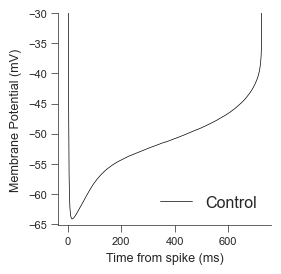

In [11]:
#Here we will plot the voltage trajectories for the control group. This function will plot the voltage trajectories for the control group. You can check the params for each function to see the input parameter requirements.
plot_average_voltage_trajectory(control_noise_mean_trace, control_noise_isi, 'Control', 'black', False, 'Control')

,slope,mean_voltage,min_voltage
0,21.908115,-59.843235,-62.836228
1,16.047731,-57.929566,-61.564397
2,17.589162,-58.546720,-61.203251
3,24.398381,-50.272668,-54.127300
4,21.175500,-69.007059,-70.507254
5,10.497304,-74.337862,-75.685518
6,17.773037,-62.491387,-67.102793
7,9.660633,-62.274884,-69.537463
8,19.974245,-56.187101,-60.802913
9,23.632416,-62.020794,-66.859554


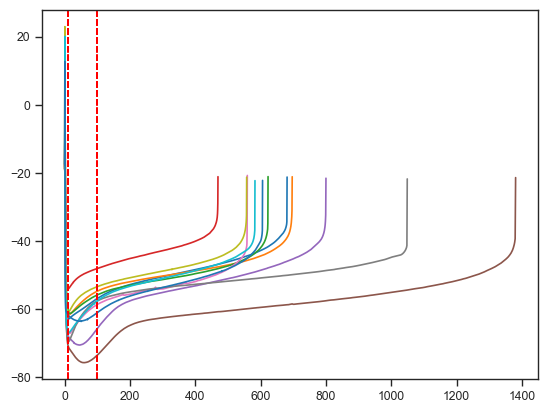

In [12]:
#here we calculate the slopes and mean voltages for the group. This function will calculate the slopes and mean voltages for the group. You can check the params for each function to see the input parameter requirements.
#control slopes and mean voltages

save_path = 'Output path'
control_slopes = calculate_slope_and_mean_voltage_50ms_window(control_noise_global_mean_traces, control_noise_global_mean_isis, save_path, 'control')

control_slopes

In [14]:
os.chdir('..')

In [15]:
os.getcwd()

'/Users/HBLANKEN/Library/CloudStorage/OneDrive-UniversityofOklahoma/Beckstead Lab/DA-AD paper files/Example_directory_code_workflow/Example Files'

In [16]:
#Here we collect the spike voltages to work off of
control_global_spike_voltages, control_mean_spike_voltages = mean_spike_voltages(os.getcwd(), 0, 50, -10, 'Control')

Working on 230405 015.axgd
Working on 230405 019.axgd
Working on 230405 027.axgd
Working on 230405 036.axgd
Working on 230405 043.axgd
Working on 230405 049.axgd
Working on 230406 006.axgd
Working on 230406 017.axgd
Working on 230406 021.axgd
Working on 230406 026.axgd
Working on 230406 031.axgd


In [20]:
os.chdir('..')

In [18]:
#calcualte the spike width and thresholds from the spike voltages
calculate_spike_widths_and_thresholds(control_global_spike_voltages, 20_000, 10, 'WT', save_path)

,spike_width_half_max,threshold
230405 015.axgd,1.510,-39.557529
230405 019.axgd,1.530,-40.654488
230405 027.axgd,1.535,-42.593185
230405 036.axgd,1.495,-37.990086
230405 043.axgd,1.500,-41.002277
230405 049.axgd,1.525,-45.162502
230406 006.axgd,1.550,-46.162323
230406 017.axgd,1.510,-45.386127
230406 021.axgd,1.495,-41.543777
230406 026.axgd,1.495,-43.660732


In [21]:
#here we calculate the frequency and cv for the group. This function will calculate the frequency and cv for the group. You can check the params for each function to see the input parameter requirements.
collect_frequency_and_cv(os.getcwd(), 20000, 0, -10, 0, 10, 'control')

Working on 230405 015.axgd
Working on 230405 019.axgd
Working on 230405 027.axgd
Working on 230405 036.axgd
Working on 230405 043.axgd
Working on 230405 049.axgd
Working on 230406 006.axgd
Working on 230406 017.axgd
Working on 230406 021.axgd
Working on 230406 026.axgd
Working on 230406 031.axgd


,Frequency,CV_ISI,Metadata
filename,,,
230405 015.axgd,1.670539,0.057338,control
230405 019.axgd,1.601570,0.080586,control
230405 027.axgd,1.687399,0.084143,control
230405 036.axgd,2.715134,0.062650,control
230405 043.axgd,1.537582,0.024439,control
230405 049.axgd,0.714495,0.035237,control
230406 006.axgd,1.950452,0.095723,control
230406 017.axgd,0.945259,0.057862,control
230406 021.axgd,1.850311,0.135098,control
